# Introuducción

Este dataset fue creado y donado por ZeMA GmbH, un centro de investigación y desarrollo en mecatrónica y tecnologías de automatización ubicado en Alemania.

El dataset fue recopilado realizando (experimentalmente) ciclos sucesivos de 60 segundos de duración sobre un Rig Hidráulico. El Rig consiste en un circuito primario de trabajo, y un circuito secundario de enfriamiento/filtración que se conectan a traves de un tanque de aceite. 

<br />

<div style="clear: both">
<img src="img/System.png" style="width: 1000px;float:left">
</div>

<div style="clear: both">
</div>

<br />

El sistema repite ciclos de trabajo variando el estado de 4 componentes mientras se miden diferentes señales de proceso.
El objetivo es poder predecir el estado / condición de los componentes a partir de las señales de proceso.


Componentes:
* Enfriador. 3 clases: Eficiencia optima, eficiencia reducida, riesgo de falla total.
* Valvula. 4 clases: comportamiento de apertura y cierre optimo, retraso / atascamiento leve, retraso severo, riesgo de falla total.
* Fugas internas en bomba. 3 clases: sin fugas, pequeñas fugas, fugas severas.
* Presión en acumulador hidráulico. 4 clases: presión óptima, presión levemente reducida, presión severamente reducida, cercano a falla total.


In [3]:
import pickle as pkl
import pandas as pd
import numpy as np
from scipy import stats


%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
from matplotlib import pyplot as plt
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (20, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.size'] = 20

import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils.vis_utils import plot_model
from funpymodeling.exploratory import status, freq_tbl, profiling_num

In [11]:
path = './dataset/'

with open(path+ 'df_data_structured.pkl','rb') as file:
    df_x=pkl.load(file)

with open(path + 'df_output_structured.pkl','rb') as file:
    df_y=pkl.load(file)

# Analisis básico de datos


## Señales de entrada

* Tamaño del dataset.
* Imprimir los nombres de las señales.
* Imprimir la primera fila de las señales.
* Imprimir los tipos de datos de cada señal.
* Graficar las señales.
* Obtener estadísticos básicos.

In [42]:
[df_x.shape, len(df_x.dtype.names)]

[(2205, 6000), 17]

El dataset posee la medición de 2205 ciclos de 17 señales con 6000 puntos cada ciclo. 

In [50]:
df_x.dtype.names

('PS1',
 'PS2',
 'PS3',
 'PS4',
 'PS5',
 'PS6',
 'EPS1',
 'FS1',
 'FS2',
 'TS1',
 'TS2',
 'TS3',
 'TS4',
 'VS1',
 'SE',
 'CE',
 'CP')

Las señales medidas son:
- 6 presiones en bar en diferentes zonas. PS1-PS6
- Potencia de bomba principal. EPS1
- Flujo (estimo en circuito primario y secundario). FS1 FS2
- 4 temperaturas en diferentes zonaas. TS1 - TS4
- Vibraciones. VS1
- Eficiencia de enfriamiento. SE
- Potencia de enfriamiento. CE
- Factor de eficiencia. CP

In [38]:
df_x[0]

array([(151.47000122, 125.5       , 2.30500007, 0., 9.93599987, 9.81799984, 2411.60009766, 8.98999977, 10.1789999, 35.56999969, 40.96099854, 38.31999969, 30.36300087, 0.60399997, 68.03900146, 47.20199966, 2.18400002),
       (151.44999695, 125.38999939, 2.30500007, 0., 9.94699955, 9.82299995, 2411.60009766,        nan,        nan,         nan,         nan,         nan,         nan,        nan,         nan,         nan,        nan),
       (151.52000427, 125.40000153, 2.33599997, 0., 9.96399975, 9.84399986, 2411.60009766,        nan,        nan,         nan,         nan,         nan,         nan,        nan,         nan,         nan,        nan),
       ...,
       (151.1000061 , 125.11000061, 2.25      , 0., 9.74499989, 9.63899994, 2409.60009766,        nan,        nan,         nan,         nan,         nan,         nan,        nan,         nan,         nan,        nan),
       (151.21000671, 125.13999939, 2.25      , 0., 9.73999977, 9.63399982, 2409.60009766,        nan,        nan,  

Todos los valores se representan como números de punto flotante.

Observamos la presencia de nan, analizaremos luego en profundidad la causa.

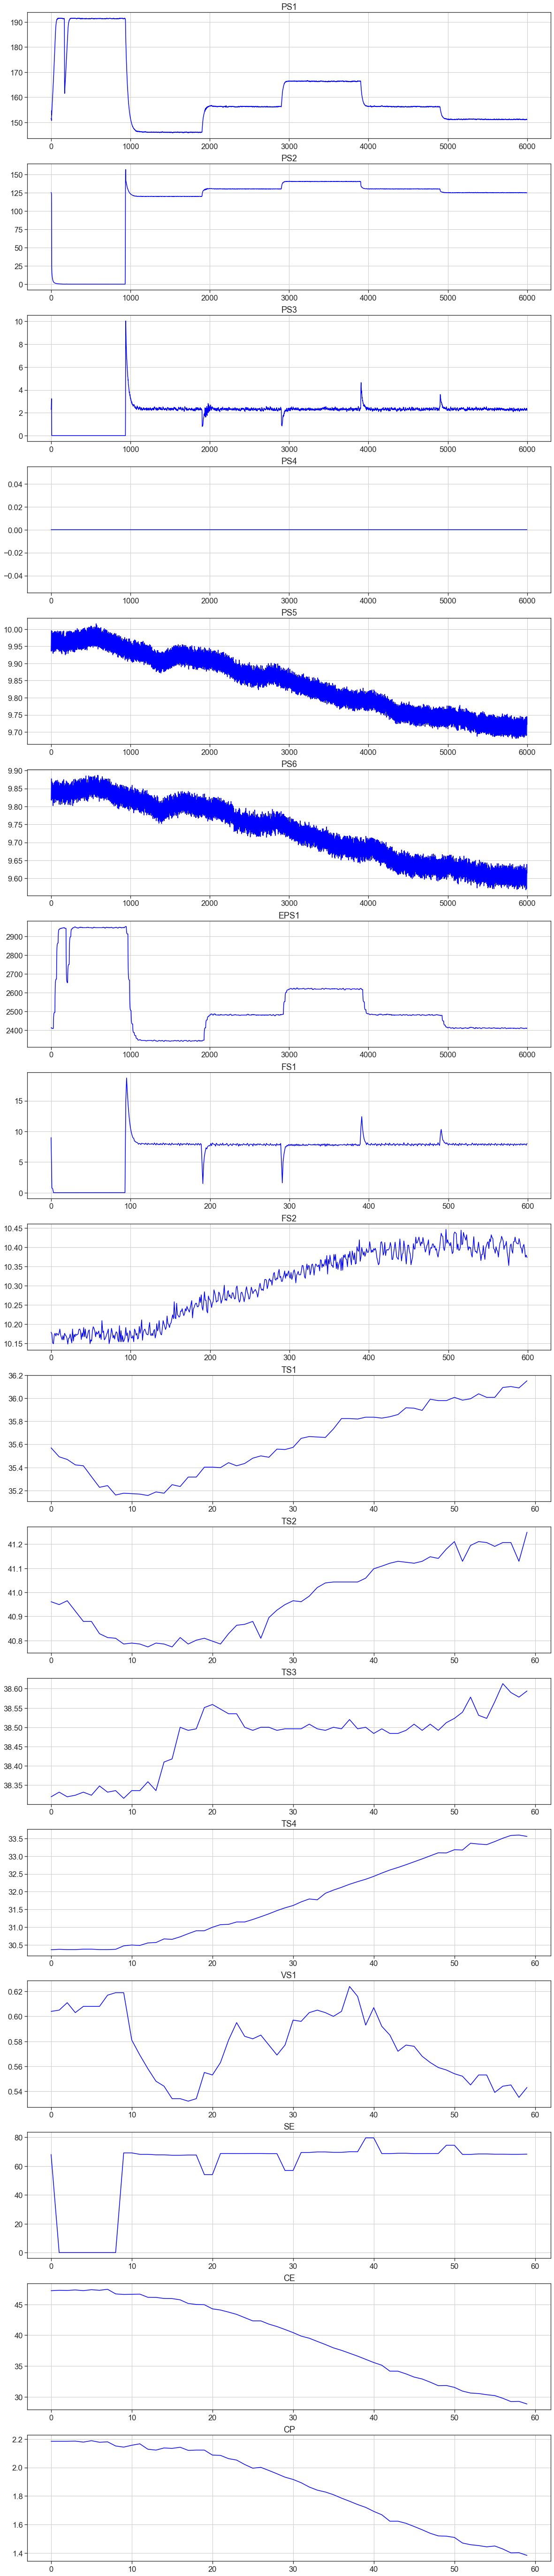

In [55]:
fig, axs = plt.subplots(17,figsize=(20, 100))
for i,col in enumerate(df_x.dtype.names):
    signal= df_x[col][0,:]
    axs[i].plot(signal[~np.isnan(signal)],color='blue',label=None)
    axs[i].set_title(col)
    axs[i].grid()

In [57]:
for col in df_x.dtype.names:
    print("----------------------------------------")
    print(col)
    print(f'nan: {np.sum(np.isnan(df_x[col]))}')
    print(f'unique: {len(np.unique(df_x[col]))}')
    print(f'min: {np.nanmin(df_x[col])}')
    print(f'max: {np.nanmax(df_x[col])}')
    print(f'mean: {np.nanmean(df_x[col])}')
    print(f'std: {np.nanstd(df_x[col])}')

----------------------------------------
PS1
nan: 0
unique: 4581
min: 133.1300048828125
max: 191.9199981689453
mean: 160.4853148787345
std: 16.13333028163704
----------------------------------------
PS2
nan: 0
unique: 12100
min: 0.0
max: 167.77000427246094
mean: 109.37990626819101
std: 48.10317157402828
----------------------------------------
PS3
nan: 0
unique: 1096
min: 0.0
max: 18.827999114990234
mean: 1.7532274926304299
std: 0.9347073805518215
----------------------------------------
PS4
nan: 0
unique: 8145
min: 0.0
max: 10.265999794006348
mean: 2.600265957945768
std: 4.297607137777727
----------------------------------------
PS5
nan: 0
unique: 1495
min: 8.317999839782715
max: 10.041000366210938
mean: 9.163320087504657
std: 0.5765989263674267
----------------------------------------
PS6
nan: 0
unique: 1433
min: 8.267999649047852
max: 9.90999984741211
mean: 9.079362751920243
std: 0.54992710636848
----------------------------------------
EPS1
nan: 0
unique: 4404
min: 2097.80004882812

## Salidas

In [60]:
df_y.dtype.names

('CoolerCondition',
 'ValveCondition',
 'Internal Pump Leakage',
 'HydraulicAcumulator',
 'StableFlag')

En este caso StableFlag no se analiza por no ser un componente que se varía su condición.

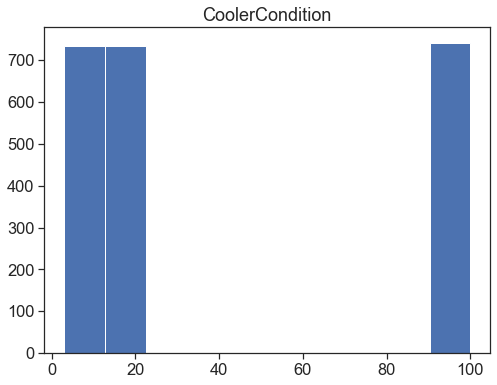

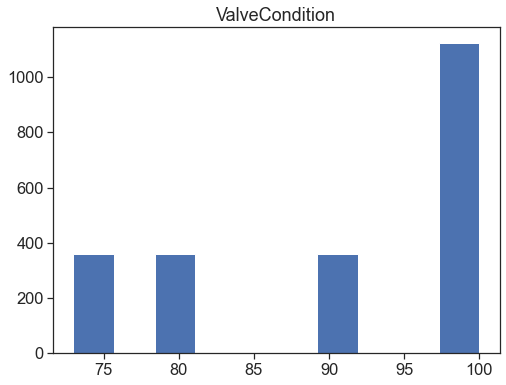

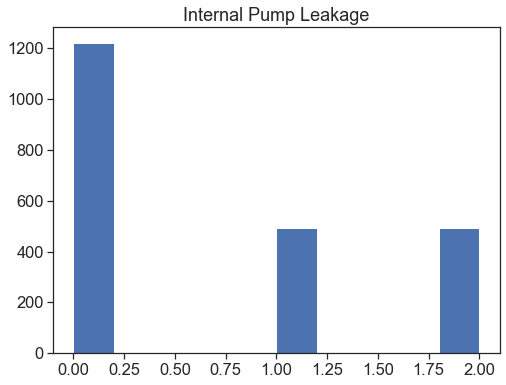

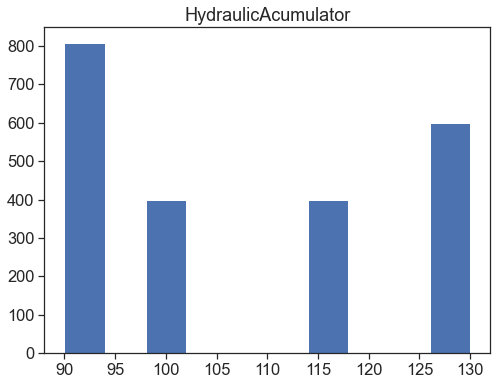

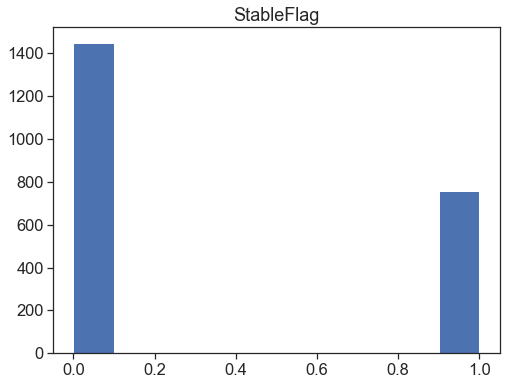

In [61]:
for col in df_y.dtype.names:
    output = df_y[col]
    fig, ax = plt.subplots(1,figsize=(8,6))
    ax.hist(output)
    ax.set_title(col)

# DECIDIR CODIFICACION DIFERENTE?

Por lo que se puede observar las variables de salida poseen valores numéricos que representan la condición de los componentes.
El problema se puede dividir como 4 problemas de clasificación multiclase.

# Limpieza de datos

*   Analizar la cantidad de NaNs
*   Darle un tratamiento a los NaNs




In [62]:
# Imprimo cantidad de nan por señal
for col in df_x.dtype.names:
    print(f'{col} nan: {np.sum(np.isnan(df_x[col]))}')

PS1 nan: 0
PS2 nan: 0
PS3 nan: 0
PS4 nan: 0
PS5 nan: 0
PS6 nan: 0
EPS1 nan: 0
FS1 nan: 11907000
FS2 nan: 11907000
TS1 nan: 13097700
TS2 nan: 13097700
TS3 nan: 13097700
TS4 nan: 13097700
VS1 nan: 13097700
SE nan: 13097700
CE nan: 13097700
CP nan: 13097700


In [64]:
# Analizo los primeros valores de FS1 
df_x['FS1'][0,0:100]

array([8.98999977e+00,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan, 7.69999981e-01,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
       6.40999973e-01,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan, 6.00000005e-03,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
       0.00000000e+00,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan, 0.00000000e+00,            nan,
                  nan,            nan,            nan,            nan,
      

In [77]:
np.argwhere(~np.isnan(df_x['FS1'][0,:])).T

array([[   0,   10,   20,   30,   40,   50,   60,   70,   80,   90,  100,
         110,  120,  130,  140,  150,  160,  170,  180,  190,  200,  210,
         220,  230,  240,  250,  260,  270,  280,  290,  300,  310,  320,
         330,  340,  350,  360,  370,  380,  390,  400,  410,  420,  430,
         440,  450,  460,  470,  480,  490,  500,  510,  520,  530,  540,
         550,  560,  570,  580,  590,  600,  610,  620,  630,  640,  650,
         660,  670,  680,  690,  700,  710,  720,  730,  740,  750,  760,
         770,  780,  790,  800,  810,  820,  830,  840,  850,  860,  870,
         880,  890,  900,  910,  920,  930,  940,  950,  960,  970,  980,
         990, 1000, 1010, 1020, 1030, 1040, 1050, 1060, 1070, 1080, 1090,
        1100, 1110, 1120, 1130, 1140, 1150, 1160, 1170, 1180, 1190, 1200,
        1210, 1220, 1230, 1240, 1250, 1260, 1270, 1280, 1290, 1300, 1310,
        1320, 1330, 1340, 1350, 1360, 1370, 1380, 1390, 1400, 1410, 1420,
        1430, 1440, 1450, 1460, 1470, 

Observamos que FS1 está muestreada cada 10 muestras de PS1.
Los nan se corresponden a momentos donde no se muestrea la señal por tener diferentes frecuencias de adquisición.

* FS1 y FS2 están muestreadas a una frecuencia 10 veces menor a PS1

In [78]:
np.argwhere(~np.isnan(df_x['TS1'][0,:])).T

array([[   0,  100,  200,  300,  400,  500,  600,  700,  800,  900, 1000,
        1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100,
        2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200,
        3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300,
        4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400,
        5500, 5600, 5700, 5800, 5900]], dtype=int64)

* TS1 a TS4, VS1, SE, CE, y CP están muestreadas a una frecuencia 100 veces menor a PS1.

Para tratar los NaN podemos submuestrear todas las señales a la frecuencia mas baja, pero perderíamos muchos datos en el proceso. Se opta por rellenar los NaN con interpolaciones.